This notebooks shows a simple example of translating a Caffe model, and runs the corresponding computation in caffe2.

In [1]:
%matplotlib inline
from caffe.proto import caffe_pb2
from caffe2.proto import caffe2_pb2
from cStringIO import StringIO
from google.protobuf import text_format
from IPython import display
import matplotlib.image as mpimg
from matplotlib import pyplot
import numpy as np
import os
from pycaffe2 import caffe_translator, utils, visualize, workspace, net_drawer
import skimage
import skimage.io
import skimage.transform
import sys

loaded nvd3 IPython extension
run nvd3.IPython_wrapper.initialize_javascript() to set up the notebook
help(nvd3.IPython_wrapper.initialize_javascript) for options
Couldn't import dot_parser, loading of dot files will not be possible.


Now, for this demo, we ask that you have the original caffe repository ready, since caffe2 does not store the caffe models. Note that you would not need to compile the caffe code over there - we merely need to obtain the models from the Caffe model zoo. We will use the bvlc_reference_caffenet as an example here. Note that since it's a big model, it takes a while to load the protocol buffer in Python. Pro tip: if your python protocol buffer is compiled to use underlying C++ implementation, it might be much faster.

In [2]:
CAFFE_ROOT = '/Users/jiayq/Research/codes/caffe'
MODEL = 'bvlc_reference_caffenet'
# If you would like to use the bvlc reference googlenet, use the following line.
# MODEL = 'bvlc_googlenet'

print 'Download model...'
os.system(os.path.join(CAFFE_ROOT, 'scripts/download_model_binary.py') + ' ' +
          os.path.join(CAFFE_ROOT, 'models', MODEL))
os.system(os.path.join(CAFFE_ROOT, 'data/ilsvrc12/get_ilsvrc_aux.sh'))
CAFFE_MODEL_FILE = os.path.join(
    CAFFE_ROOT, 'models', MODEL, 'deploy.prototxt')
CAFFE_PRETRAINED = os.path.join(
    CAFFE_ROOT, 'models', MODEL, MODEL + '.caffemodel')
IMAGE_FILE = 'images/cat.jpg'
print 'Loading models...'
caffenet = caffe_pb2.NetParameter()
caffenet_pretrained = caffe_pb2.NetParameter()
text_format.Merge(open(CAFFE_MODEL_FILE).read(), caffenet)
caffenet_pretrained.ParseFromString(open(CAFFE_PRETRAINED).read())

Download model...
Loading models...


Let's translate the Caffe model. The translation script will produce two outputs: one is a Caffe2 net that describes all the computations, and one is the collection of pretrained parameters. Note that in Caffe2, a net purely describes the computation and does not host the parameters (unlike a Caffe layer). For example, a Caffe Convolution layer will have the weight and the bias as two internal parameter blobs, while in Caffe2, a convolution operator is a thin operator that takes in three inputs: the data, the weight, and the bias.

In [3]:
# Perform translation, using the caffenet and pretrained parameters.
print 'Translating model.'
net, pretrained_params = caffe_translator.TranslateModel(
    caffenet, caffenet_pretrained)
# Now, since this network involves dropout, we explicitly remove it for testing purpose.
caffe_translator.DeleteDropout(net)

Translating model.
Translate layer conv1
Translate layer relu1
Translate layer pool1
Translate layer norm1
Translate layer conv2
Translate layer relu2
Translate layer pool2
Translate layer norm2
Translate layer conv3
Translate layer relu3
Translate layer conv4
Translate layer relu4
Translate layer conv5
Translate layer relu5
Translate layer pool5
Translate layer fc6
Translate layer relu6
Translate layer drop6
Translate layer fc7
Translate layer relu7
Translate layer drop7
Translate layer fc8
Translate layer prob


You can inspect the content of the network using "print str(net)", but let's use a more visually appealing approach to print it.

CaffeNet


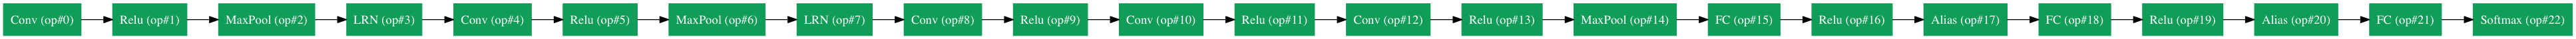

In [4]:
graph = net_drawer.GetPydotGraphMinimal(net.operators, net.name, rankdir="LR")
print net.name
display.Image(graph.create_png(), width=800)
# The above command shows only the operators. If you want to see both the
# operators and the blobs, use the command below.
#graph = net_drawer.GetPydotGraph(net.operators, net.name, rankdir="BT")
#display.Image(graph.create_png(), width=500)

It is possible to write a Python wrapper that deals with all the image I/Os similar to what we did in Caffe. However, as an illustrative example, what we do here is to show how you can read a single image, do a few preprocessing, and feeds it into the classifier to obtain the prediction.

First of all, Caffe2 now requires you to specify what device you want to run on. This is enabled by setting the device_option field in the network protocol buffer. Note that once a network is created, we do not support switching device back and forth; however, you can always choose to re-create the network on a different device.

In [5]:
# Here are the parameters that this model has.
print [tensor.name for tensor in pretrained_params.protos]

[u'conv1_w', u'conv1_b', u'conv2_w', u'conv2_b', u'conv3_w', u'conv3_b', u'conv4_w', u'conv4_b', u'conv5_w', u'conv5_b', u'fc6_w', u'fc6_b', u'fc7_w', u'fc7_b', u'fc8_w', u'fc8_b']


In [6]:
# We will first specify the device option: how we want to run the network.
net.device_option.device_type = caffe2_pb2.CPU
# If you want to use cuda, use the following commands
#net.device_option.device_type = caffe2_pb2.CUDA
#net.device_option.cuda_gpu_id = 0

# pycaffe2.workspace implements a very simple Model object that wraps the construction
# of the model. Specifically, what it did was:
# (1) feed the parameters to the workspace;
# (2) Create input blob placeholders;
# (3) Actually instantiating the Caffe network.
# Here we will simply use the Model object to host the model.

model = workspace.Model(net, pretrained_params, ["data"], ["prob"])
print 'Network created sucessfully.'

Network created sucessfully.


Now, let's load an image and do a little preprocessing so we can feed it into the network. This could be wrapped in a preprocessor class (as Caffe did), but here we will list out each single step so we can better see what happens in it.

Input shape is 227x227
Final input shape is: (1, 3, 227, 227)


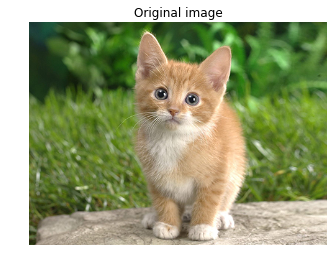

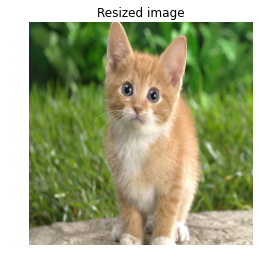

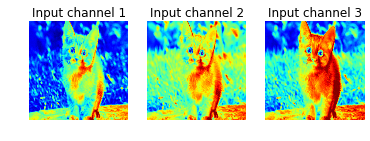

In [7]:
img = skimage.img_as_float(skimage.io.imread(IMAGE_FILE)).astype(np.float32)
pyplot.imshow(img)
pyplot.axis('off')
pyplot.title('Original image')
# Here are the steps we use to preprocess the image.
# (1) Resize the image to 256*256, and crop out the center.
input_height, input_width = caffenet.input_dim[-2:]
print 'Input shape is %dx%d' % (input_height, input_width)
img = skimage.transform.resize(img, (256, 256))
crop_height = (256 - input_height) / 2
crop_width = (256 - input_width) / 2
img = img[crop_height:crop_height + input_height, 
          crop_width:crop_width + input_width]
pyplot.figure()
pyplot.imshow(img)
pyplot.axis('off')
pyplot.title('Resized image')
# (2) Since Caffe expects CHW order and the current image is HWC,
#     we will need to change the order.
img = img.swapaxes(1, 2).swapaxes(0, 1)
# (3) Caffe uses a BGR order due to legacy OpenCV issues, so we
#     will change RGB to BGR.
img = img[(2, 1, 0), :, :]
# (4) We will subtract the mean image. Note that skimage loads
#     image in the [0, 1] range so we multiply the pixel values
#     first to get them into [0, 255].
mean_file = os.path.join(CAFFE_ROOT, 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
mean = np.load(mean_file).mean(1).mean(1)
img = img * 255 - mean[:, np.newaxis, np.newaxis]
pyplot.figure()
for i in range(3):
    # For some reason, pyplot subplot follows Matlab's indexing
    # convention (starting with 1). Well, we'll just follow it...
    pyplot.subplot(1, 3, i+1)
    pyplot.imshow(img[i])
    pyplot.axis('off')
    pyplot.title('Input channel %d' % (i+1))
# (5) finally, since caffe2 expect the input to have a batch term
#     so we can feed in multiple images, we will simply prepend a
#     batch dimension of size 1. Also, we will make sure image is
#     of type np.float32.
img = img[np.newaxis, :, :, :].astype(np.float32)
print 'Final input shape is:', img.shape

Running the network is relatively simple.

Max prediction is: 281


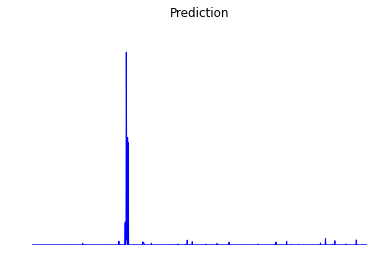

In [8]:
results = model.Run([img])
prob = workspace.FetchBlob('prob').flatten()
pyplot.plot(prob)
pyplot.title('Prediction')
pyplot.axis('off')
print 'Max prediction is:', prob.argmax()

This completes the short demo for translating a Caffe model. Once you have translated a Caffe model to caffe2, it is no different from standard Caffe2 trained models.